In [42]:
%cd '../HOTS'
from Tools import netparam, knn, JensenShannon, BattachaNorm, histoscore, histoscore_lagorce
import numpy as np
import matplotlib.pyplot as plt
from os.path import isfile
import pickle

/home/antoine/homhots/HOTS/HOTS


In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
def printfig(fig, name):
    dpi_exp = None
    bbox = 'tight'
    path = '../../paper/5f22d412742c360001c92b46/fig/'
    #path = '../../GrimaldiEtAl2020HOTS_clone_laurent/fig'
    fig.savefig(path+name, dpi = dpi_exp, bbox_inches=bbox, transparent=True)

In [45]:
sigma = None
pooling = False
homeinv = False
jitonic = [None,None] #[temporal, spatial]
jitter = False
R = 2
tau = 0.07
nbclust = [4,8,16]
filt = 2

timestr = '2021-03-28'
record_path = '../Records/EXP_05_POKERDVS/'
dataset = 'poker'
nb_test = 20
nb_train = 48
ds = 1

nb_test = nb_test//ds
nb_train = nb_train//ds
print(f'training set size: {nb_train} - testing set: {nb_test}')

kNN = 3

verbose = False

training set size: 48 - testing set: 20


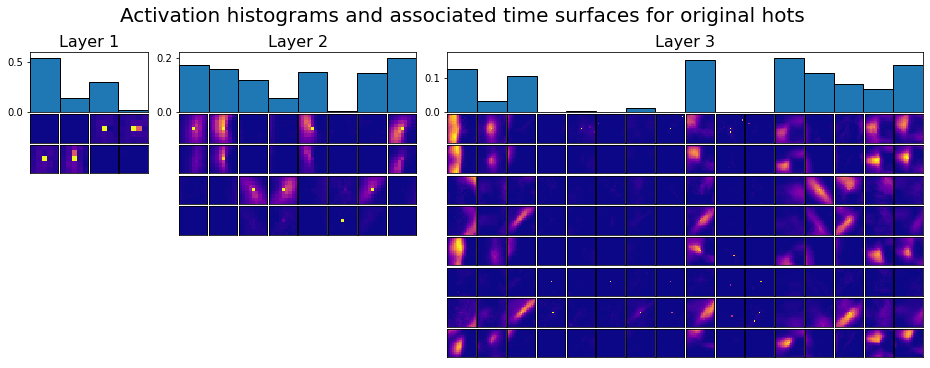

----------Averaged histograms----------
Performances for hots with Euclidian distance: 80.0%
Performances for hots with Bhattacharyya distance: 75.0%
Performances for hots with Jensen-Shannon distance: 75.0%
---------Per sample histograms---------
Performances for hots with  k-NN (k=3): 95.0%
Performances for hots with  k-NN using Jensen-Shannon as a metric (k=3): 95.0%


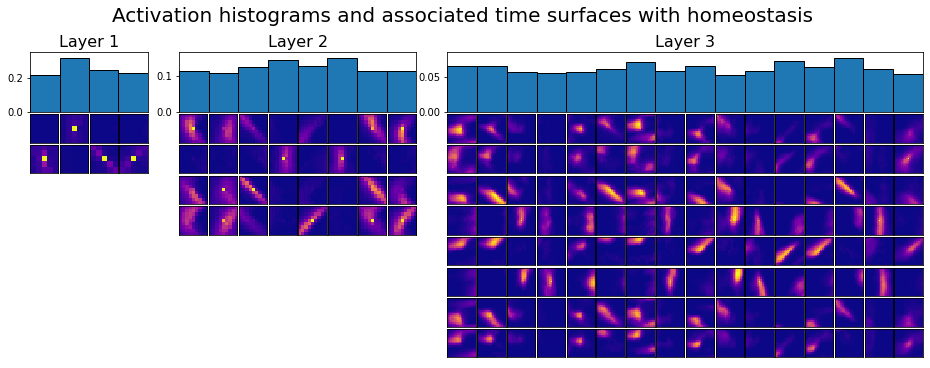

----------Averaged histograms----------
Performances for homhots with Euclidian distance: 75.0%
Performances for homhots with Bhattacharyya distance: 75.0%
Performances for homhots with Jensen-Shannon distance: 75.0%
---------Per sample histograms---------
Performances for homhots with  k-NN (k=3): 100.0%
Performances for homhots with  k-NN using Jensen-Shannon as a metric (k=3): 100.0%


In [46]:
for name in ['hots', 'homhots']:
    f_name = f'{record_path}{timestr}_results_fullset_histo_{name}.pkl'
    hotshom, homeotest = netparam(name, filt, tau, nbclust, sigma, homeinv, jitter, timestr, dataset, R)#, nb_learn=50)
    hotshom.plotlayer()
    if isfile(f_name):
        with open(f_name, 'rb') as file:
            scores = pickle.load(file)
    else:
        trainhistomap = hotshom.running(homeotest=homeotest, nb_digit = nb_train, outstyle='histo', dataset=dataset, verbose=verbose)
        testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic, dataset=dataset, verbose=verbose)
        JS_kNN_score = knn(trainhistomap,testhistomap, k = kNN, weights = 'distance', metric = JensenShannon)
        kNN_score = knn(trainhistomap,testhistomap, k = kNN, weights = 'distance')
        
        trainhistomapav = hotshom.running(homeotest=homeotest, nb_digit = nb_train, outstyle='histav', dataset=dataset, verbose=verbose)
        trainhistomapav2 = []
        for i in range(trainhistomapav.shape[0]):
            trainhistomapav2.append([i,trainhistomapav[i,:]])
        JS_score = knn(trainhistomapav2,testhistomap, k = 1, weights = 'uniform', metric = JensenShannon)
        BA_score = knn(trainhistomapav2,testhistomap, k = 1, weights = 'uniform', metric = BattachaNorm)
        EU_score = knn(trainhistomapav2,testhistomap, k = 1, weights = 'uniform')

        scores = [EU_score, BA_score, JS_score, kNN_score, JS_kNN_score]
        with open(f_name, 'wb') as file:
            pickle.dump(scores, file, pickle.HIGHEST_PROTOCOL)
        
    print('----------Averaged histograms----------')
    print(f'Performances for {name} with Euclidian distance: {np.round(scores[0],3)*100}%')
    print(f'Performances for {name} with Bhattacharyya distance: {np.round(scores[1],3)*100}%')
    print(f'Performances for {name} with Jensen-Shannon distance: {np.round(scores[2],3)*100}%')
    print('---------Per sample histograms---------')
    print(f'Performances for {name} with  k-NN (k={kNN}): {np.round(scores[3],3)*100}%')
    print(f'Performances for {name} with  k-NN using Jensen-Shannon as a metric (k={kNN}): {np.round(scores[4],3)*100}%')

# Trying the variability with different clustering (unsupervised learning of the features)

In [47]:
verbose=False
JS_score = []
JS_scorehom = []
JS_score_histav = []
JS_scorehom_histav = []
BA_score = []
BA_scorehom = []
BA_score_histav = []
BA_scorehom_histav = []
kNN6_score = []
kNN6_scorehom = []
kNN3_score = []
kNN3_scorehom = []

tau = 0.07

for name in ['hots', 'homhots']:
    for i in range(100):
        timestr = '2021-04-14_'+str(i)
        hotshom, homeotest = netparam(name, filt, tau, nbclust, sigma, homeinv, jitter, timestr, dataset, R, verbose=verbose)#, nb_learn=50)
        trainhistomap = hotshom.running(homeotest=homeotest, nb_digit = nb_train, outstyle='histo', dataset=dataset, verbose=verbose)
        testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic, dataset=dataset, verbose=verbose)
        score = histoscore(trainhistomap,testhistomap, verbose = verbose)
        if name=='hots':
            BA_score.append(score[0]*100)
            JS_score.append(score[4]*100)
            kNN3_score.append(score[5]*100)
            kNN6_score.append(score[6]*100)
        else:
            BA_scorehom.append(score[0]*100)
            JS_scorehom.append(score[4]*100)
            kNN3_scorehom.append(score[5]*100)
            kNN6_scorehom.append(score[6]*100)
        trainhistomap = hotshom.running(homeotest=homeotest, nb_digit = nb_train, outstyle='histav', dataset=dataset, verbose=verbose)
        score = histoscore_lagorce(trainhistomap,testhistomap, verbose = verbose)
        if name=='hots':
            BA_score_histav.append(score[0]*100)
            JS_score_histav.append(score[4]*100)
        else:
            BA_scorehom_histav.append(score[0]*100)
            JS_scorehom_histav.append(score[4]*100)

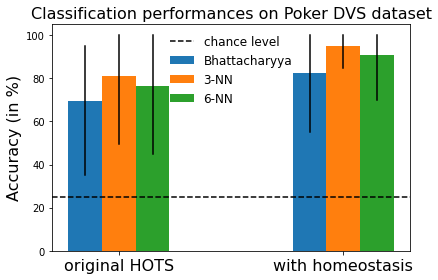

In [48]:
labels = ['original HOTS', 'with homeostasis']

JS_means = [np.mean(JS_score_histav), np.mean(JS_scorehom_histav)]
BA_means = [np.mean(BA_score_histav), np.mean(BA_scorehom_histav)]
kNN3_means = [np.mean(kNN3_score), np.mean(kNN3_scorehom)]
kNN6_means = [np.mean(kNN6_score), np.mean(kNN6_scorehom)]

JS_quant = [[np.quantile(JS_score_histav, 0.05),np.quantile(JS_score_histav, 0.95)], [np.quantile(JS_scorehom_histav, 0.05),np.quantile(JS_scorehom_histav, 0.95)]]
BA_quant = [[np.quantile(BA_score_histav, 0.05),np.quantile(BA_score_histav, 0.95)], [np.quantile(BA_scorehom_histav, 0.05),np.quantile(BA_scorehom_histav, 0.95)]]
kNN3_quant = [[np.quantile(kNN3_score, 0.05),np.quantile(kNN3_score, 0.95)], [np.quantile(kNN3_scorehom, 0.05),np.quantile(kNN3_scorehom, 0.95)]]
kNN6_quant = [[np.quantile(kNN6_score, 0.05),np.quantile(kNN6_score, 0.95)], [np.quantile(kNN6_scorehom, 0.05),np.quantile(kNN6_scorehom, 0.95)]]

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
#rects1 = ax.bar(x - 3/2*width, JS_means, width, label='Jensen-Shannon')
rects2 = ax.bar(x - width, BA_means, width, label='Bhattacharyya')
rects3 = ax.bar(x, kNN3_means, width, label='3-NN')
rects4 = ax.bar(x + width, kNN6_means, width, label='6-NN')

for i in range(len(x)):
    #ax.plot([x[i] - 3/2*width,x[i] - 3/2*width], JS_quant[i], '-k')
    ax.plot([x[i] - width,x[i] - width], BA_quant[i], '-k')
    ax.plot([x[i],x[i]], kNN3_quant[i], '-k')
    ax.plot([x[i]+width,x[i]+width], kNN6_quant[i], '-k')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.axhline(25, 0, 1, linestyle='--', color='k', label='chance level')
ax.set_ylabel('Accuracy (in %)', fontsize=16)
ax.set_title('Classification performances on Poker DVS dataset', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=16)
leg = ax.legend(loc='upper center',fontsize=12)
leg.get_frame().set_alpha(0)

fig.tight_layout()

plt.show()

In [49]:
printfig(fig, 'poker_histo.pdf')

# Online classification performance

In [50]:
from Tools import fit_data, predict_data, classification_results

In [51]:
sigma = None
pooling = False
homeinv = False
jitonic = [None,None] #[temporal, spatial]
jitter = False
R = 2
tau = 0.07
nbclust = [4,8,16]
filt = 2

timestr = '2021-03-28'
record_path = '../Records/EXP_05_POKERDVS/'
dataset = 'poker'
nb_test = 20
nb_train = 48
ds = 1

nb_test = nb_test//ds
nb_train = nb_train//ds
print(f'training set size: {nb_train} - testing set: {nb_test}')

kNN = 3

verbose = False

training set size: 48 - testing set: 20


In [52]:
num_workers = 0
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
print(f'number of epochs: {num_epochs}')
ds_ev = 1
tau_cla = 1e4
nb_class = 4

number of epochs: 33


In [53]:
step = 0.05
namelist = ['raw','hots', 'homhots']
mean_acc = np.zeros([len(namelist),len(np.arange(0,1,step))])
last_acc = np.zeros([len(namelist),len(np.arange(0,1,step))])
true_positive = np.zeros([len(namelist),len(np.arange(0,1,step))])
false_positive = np.zeros([len(namelist),len(np.arange(0,1,step))])

for namnum, name in enumerate(namelist):
    f_name = f'{record_path}{timestr}_LR_results_{name}_{nbclust}_{nb_train}_{nb_test}_{ds_ev}.pkl'
    if isfile(f_name):
        with open(f_name, 'rb') as file:
            likelihood, true_target, time_scale = pickle.load(file)
    else:
        print(f'LR fit for {name}...')
        model, loss  = fit_data(name,timestr,record_path,filt,tau,R,nbclust,sigma,homeinv,jitter,dataset,nb_train,ds_ev, learning_rate, num_epochs,betas, tau_cla=tau_cla,jitonic=jitonic,subset_size=None,num_workers=num_workers,verbose=False)
        print(f'prediction for {name}...')
        likelihood, true_target, time_scale = predict_data(model,name,timestr,record_path,filt,tau,R,nbclust,sigma, homeinv,jitter,dataset,nb_test,ds_ev, tau_cla,jitonic=jitonic,subset_size=None,num_workers=num_workers, verbose=False)
        with open(f_name, 'wb') as file:
            pickle.dump([likelihood, true_target, time_scale], file, pickle.HIGHEST_PROTOCOL)
    
    thresnum = 0
    for thres in [None]:#np.arange(0,1,step):
        meanac, onlinac, lastac, truepos, falsepos = classification_results(likelihood, true_target, thres, nb_test, 1/nb_class)
        last_acc[namnum,thresnum] = lastac
        mean_acc[namnum,thresnum] = meanac
        true_positive[namnum,thresnum] = truepos
        false_positive[namnum,thresnum] = falsepos
        thresnum+=1

/home/antoine/homhots/HOTS/HOTS/Tools.py:537: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


In [54]:
def norm(x):
    x = np.array(x)
    x = (x-min(x))/(max(x)-min(x))
    return x

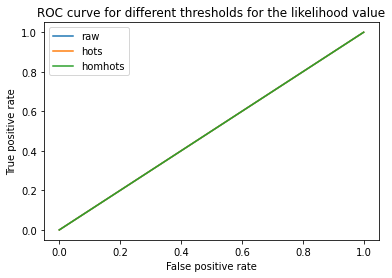

In [55]:
for i in range(3):
    plt.plot(norm(false_positive[i,:]), norm(true_positive[i,:]), label=namelist[i]);
plt.title('ROC curve for different thresholds for the likelihood value');
plt.xlabel('False positive rate');
plt.ylabel('True positive rate');
plt.legend();

In [56]:
from scipy.optimize import curve_fit
def fitting(x, a, b):
    #return a*np.tanh(x*b)
    return 1-np.exp(-(b*x)**a)

/home/antoine/homhots/HOTS/HOTS/Tools.py:537: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)
/home/antoine/homhots/HOTS/HOTS/Tools.py:537: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


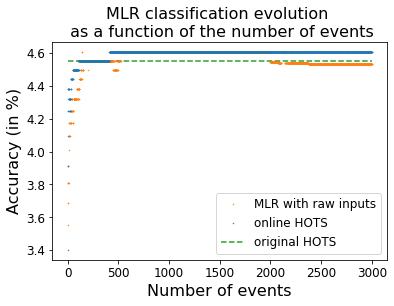

In [57]:
thres = None
colorz = ['#ff7f0e', '#1f77b4', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
legend_list = ['original HOTS', 'MLR with raw inputs', 'online HOTS']
namelist = ['raw', 'homhots']
fig_onl, ax_onl = plt.subplots()
ax_onl.hlines(np.log(95),0,3000, linestyles='dashed', color=colorz[2], label=legend_list[0])
for namnum, name in enumerate(namelist):
    f_name = f'{record_path}{timestr}_LR_results_{name}_{nbclust}_{nb_train}_{nb_test}_{ds_ev}.pkl'
    with open(f_name, 'rb') as file:
        likelihood, true_target, time_scale = pickle.load(file)
    meanac, onlinac, lastac, truepos, falsepos = classification_results(likelihood, true_target, thres, nb_test, 1/nb_class)
    #pars, cov = curve_fit(f=fitting, xdata=np.arange(len(onlinac)), ydata=onlinac, p0=[1,1], bounds=(-np.inf, np.inf))
    #fit = fitting(np.arange(len(onlinac)), *pars)
    ax_onl.plot(np.log(onlinac[:3000]*100), '.', ms=1, color=colorz[namnum], label = legend_list[namnum+1]);
    #ax_onl.plot(fit[:3000], linestyle='-', color=color[namnum], linewidth=1);
#ax_onl.axis([-50,3000,0,105]);
ax_onl.set_xlabel('Number of events', fontsize=16);
ax_onl.set_ylabel('Accuracy (in %)', fontsize=16);
plt.setp(ax_onl.get_yticklabels(), fontsize=12)
plt.setp(ax_onl.get_xticklabels(), fontsize=12)
ax_onl.set_title('MLR classification evolution \n as a function of the number of events', fontsize=16);
ax_onl.legend(fontsize=12, loc='lower right');

In [58]:
printfig(fig_onl, 'poker_online.pdf')

In [59]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

In [60]:
LabelBinarizer().fit_transform(np.array(true_target))

array([[0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0]])

<ipython-input-61-bf74f234c447>:31: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.axis([0,12,0.8,1.01]);


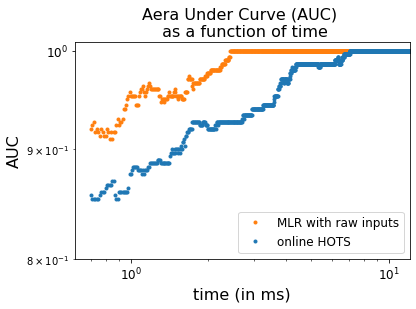

In [61]:
nb_classes = 4
timesteps = np.arange(700,12000,10)
namelist = ['raw', 'homhots']
leg_list = ['MLR with raw inputs', 'online HOTS']
colorz = ['#ff7f0e','#1f77b4', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
for namnum, name in enumerate(namelist):
    f_name = f'{record_path}{timestr}_LR_results_{name}_{nbclust}_{nb_train}_{nb_test}_{ds_ev}.pkl'
    with open(f_name, 'rb') as file:
        likelihood, true_target, time_scale = pickle.load(file)
    y_true = np.zeros([len(true_target)])
    y_score = np.zeros([len(true_target),nb_classes])
    proba_timestep = np.zeros([len(timesteps),len(true_target),nb_classes])
    i = 0
    for likelihood_, true_target_, time_scale_ in zip(likelihood, true_target, time_scale):
        time_scale_ -= time_scale_[0]
        previous_ind = 0
        for idx, step in enumerate(timesteps):
            ind = np.where(time_scale_<step)[0][-1]
            #proba = np.mean(likelihood_[previous_ind:ind,:], axis=0)
            proba = likelihood_[ind,:]
            if np.isnan(proba[0]):
                proba = proba_timestep[idx-1,i,:]
            proba_timestep[idx,i,:] = proba
        i+=1
    AUC = np.zeros([len(timesteps)])
    for idx, step in enumerate(timesteps):
        #print(proba_timestep[idx,:,:].shape, np.array(true_timestep[idx]))
        AUC[idx] = roc_auc_score(LabelBinarizer().fit_transform(np.array(true_target)),proba_timestep[idx,:,:], multi_class='ovr')
    ax.loglog(timesteps/1e3,AUC, '.', label=leg_list[namnum], color = colorz[namnum])
ax.axis([0,12,0.8,1.01]);
ax.set_xlabel('time (in ms)', fontsize=16);
ax.set_ylabel('AUC', fontsize=16);
ax.set_title('Aera Under Curve (AUC) \n as a function of time', fontsize=16);
plt.setp(ax.get_yticklabels(), fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)
ax.legend(fontsize=12, loc='lower right');

In [62]:
printfig(fig,'poker_auc.pdf')

# Robustness to jitter

In [63]:
from scipy.stats import beta
from Tools import fit_jitter
jit_s = np.arange(0,20,0.5)
jit_t = np.arange(0,20000,500)
jit_s = jit_s**2
nb_trials = 10
nb_class = 4

semi-saturation level for homhots with temporal jitter: 6.1 ms
semi-saturation level for homhots with spatial jitter: 3.05 ms


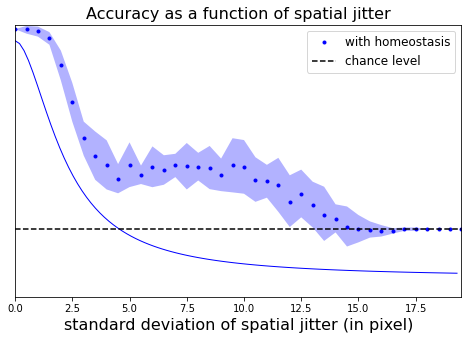

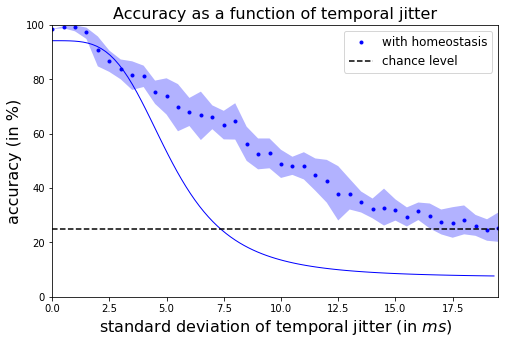

In [64]:
fig_s, ax_s = plt.subplots(1,1,figsize=(8,5))
fig_t, ax_t = plt.subplots(1,1,figsize=(8,5))

for name in ['homhots']:
    f_name = f'{record_path}{timestr}_LR_results_jitter_{name}_[4, 8, 16]_48_20_1_None.pkl'

    with open(f_name, 'rb') as file:
        results_s, results_t, results_s_last, results_t_last = pickle.load(file)
    
    jit_t_plot, jit_s_plot = jit_t/1e3, np.sqrt(jit_s)
    
    score_stat12 = np.zeros([3,len(jit_t)])
    score_stas12 = np.zeros([3,len(jit_s)])
    
    score_t12 = results_t
    score_s12 = results_s
    
    q = [0.05,0.5,0.95]
    for i in range(1,score_t12.shape[1]):
        mean = np.mean(score_t12[:,i])
        if np.unique(score_t12[:,i]).shape[0]==1:
            score_stat12[0,i], score_stat12[1,i], score_stat12[2,i] = mean, mean, mean
        else:
            var = np.std(score_t12[:,i])
            alpha12=mean**2*(1-mean)/var-mean
            beta12=alpha12*(1-mean)/mean
            paramz_t12 = beta.fit(score_t12[:,i], a=alpha12, b=beta12, floc=0, fscale = 1)
            score_stat12[0,i], score_stat12[1,i], score_stat12[2,i] = beta.ppf(q, a=paramz_t12[0], b=paramz_t12[1])
            score_stat12[1,i] = np.mean(score_t12[:,i])
        
    for j in range(score_s12.shape[1]):
        mean = np.mean(score_s12[:,j])
        if np.unique(score_s12[:,j]).shape[0]==1:
            score_stas12[0,j], score_stas12[1,j], score_stas12[2,j] = mean, mean, mean
        else:
            var = np.std(score_s12[:,j])
            alpha12=mean**2*(1-mean)/var-mean
            beta12=alpha12*(1-mean)/mean
            paramz_s12 = beta.fit(score_s12[:,j], a=alpha12, b=beta12, floc=0, fscale = 1)
            score_stas12[0,j], score_stas12[1,j], score_stas12[2,j] = beta.ppf(q, a=paramz_s12[0], b=paramz_s12[1])
            score_stas12[1,j] = np.mean(score_s12[:,j])
        
    score_stat12[:,0] = np.mean(score_t12[:,0])
    score_stas12[:,0] = np.mean(score_s12[:,0])
    if name == 'raw':
        param_T = [0.9, 5, 4, 0.1]
        param_S = [0.9, 1, 3, 0.1]
    else: 
        param_T = [0.9, 5, 4, 0.1]
        param_S = [0.9, 2, 2, 0.1]
        
    n = 33
    logistic_model_T, loss_T, fit_T = fit_jitter(param_T, jit_t_plot, np.array(score_stat12[1,:]), num_epochs=n, verbose=False) 
    logistic_model_S, loss_S, fit_S = fit_jitter(param_S, jit_s_plot, np.array(score_stas12[1,:]), num_epochs=n, verbose=False) 
    
    x_fit_S = np.arange(jit_s_plot[0],jit_s_plot[-1],(jit_s_plot[-1]-jit_s_plot[0])/100)
    x_fit_T = np.arange(jit_t_plot[0],jit_t_plot[-1],(jit_t_plot[-1]-jit_t_plot[0])/100)
    
    if name=='raw':
        
        ax_s.plot(jit_s_plot, score_stas12[1,:]*100, '.',color='red', label='original HOTS')
        ax_s.plot(x_fit_S, fit_S.detach().numpy()*100, color='red', lw=1)
        ax_s.fill_between(jit_s_plot,
            score_stas12[2,:]*100, score_stas12[0,:]*100,
            facecolor = 'red', edgecolor = None, alpha = .3)
        
        ax_t.plot(jit_t_plot, score_stat12[1,:]*100, '.',color='red', label='original HOTS')
        ax_t.plot(x_fit_T, fit_T.detach().numpy()*100, color='red', lw=1)
        ax_t.fill_between(jit_t_plot,
            score_stat12[2,:]*100, score_stat12[0,:]*100,
            facecolor = 'red', edgecolor = None, alpha = .3)
    else:
        
        ax_s.plot(jit_s_plot, score_stas12[1,:]*100, '.',color='blue', label='with homeostasis')
        ax_s.plot(x_fit_S, fit_S.detach().numpy()*100, color='blue', lw=1)
        ax_s.fill_between(jit_s_plot,
            score_stas12[2,:]*100, score_stas12[0,:]*100,
            facecolor = 'blue', edgecolor = None, alpha = .3)
        
        ax_t.plot(jit_t_plot, score_stat12[1,:]*100, '.',color='blue', label='with homeostasis')
        ax_t.plot(x_fit_T, fit_T.detach().numpy()*100, color='blue', lw=1)
        ax_t.fill_between(jit_t_plot,
            score_stat12[2,:]*100, score_stat12[0,:]*100,
            facecolor = 'blue', edgecolor = None, alpha = .3)
        
    # semi-saturation levels    
    chance = 0.1
    valmax = 0.851
    semisat = (valmax-chance)/2
    y = 1
    x = 0
    while y>semisat:
        x += 0.1
        y = logistic_model_T(x)
    print(f'semi-saturation level for {name} with temporal jitter: {np.round(x,3)} ms')
    y = 1
    x = 0
    while y>semisat:
        x += 0.01
        y = logistic_model_S(x)
    print(f'semi-saturation level for {name} with spatial jitter: {np.round(x,3)} ms')
    
chance_s = np.ones([len(jit_s_plot)])*100/nb_class
ax_s.plot(jit_s_plot,chance_s, 'k--', label='chance level')
chance_t = np.ones([len(jit_t_plot)])*100/nb_class
ax_t.plot(jit_t_plot,chance_t, 'k--', label='chance level')
ax_t.axis([0,max(jit_t_plot),0,100]);
ax_t.set_xlabel('standard deviation of temporal jitter (in $ms$)', fontsize=16);
ax_t.set_ylabel('accuracy (in %)', fontsize=16);
#ax_t.set_yticks([])
ax_t.set_title('Accuracy as a function of temporal jitter', fontsize=16);
ax_t.legend(fontsize=12);

ax_s.axis([0,max(jit_s_plot),0,100]);
ax_s.set_xlabel('standard deviation of spatial jitter (in pixel)', fontsize=16);
#ax_s.set_ylabel('accuracy (in %)', fontsize=16);
ax_s.set_yticks([])
ax_s.set_title('Accuracy as a function of spatial jitter', fontsize=16);
#plt.yticks([],[])
ax_s.legend(fontsize=12);

# Paremeter testing

In [19]:
verbose=False
JS_score = []
JS_scorehom = []
JS_score_histav = []
JS_scorehom_histav = []
BA_score = []
BA_scorehom = []
BA_score_histav = []
BA_scorehom_histav = []
kNN6_score = []
kNN6_scorehom = []
kNN3_score = []
kNN3_scorehom = []

tauz = [0.01, 0.02, 0.05, 0.07, 0.08, 0.09, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 2, 5, 10, 20, 30]

for name in ['hots', 'homhots']:
    for tau in tauz:
        hotshom, homeotest = netparam(name, filt, tau, nbclust, sigma, homeinv, jitter, timestr, dataset, R)#, nb_learn=50)
        #hotshom.plotlayer()
        trainhistomap = hotshom.running(homeotest=homeotest, nb_digit = nb_train, outstyle='histo', dataset=dataset, verbose=verbose)
        testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic, dataset=dataset, verbose=verbose)
        
        score = histoscore(trainhistomap,testhistomap, verbose = verbose)
        if name=='hots':
            BA_score.append(score[0])
            JS_score.append(score[4])
            kNN3_score.append(score[5])
            kNN6_score.append(score[6])
        else:
            BA_scorehom.append(score[0])
            JS_scorehom.append(score[4])
            kNN3_scorehom.append(score[5])
            kNN6_scorehom.append(score[6])
        trainhistomap = hotshom.running(homeotest=homeotest, nb_digit = nb_train, outstyle='histav', dataset=dataset, verbose=verbose)
        score = histoscore_lagorce(trainhistomap,testhistomap, verbose = verbose)
        if name=='hots':
            BA_score_histav.append(score[0])
            JS_score_histav.append(score[4])
        else:
            BA_scorehom_histav.append(score[0])
            JS_scorehom_histav.append(score[4])

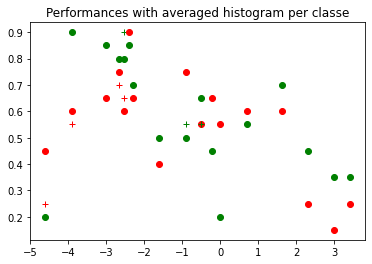

In [20]:
for i in range(len(tauz)):
    j = np.log(tauz[i])
    plt.plot(j,BA_score_histav[i], 'r +')
    plt.plot(j,JS_score_histav[i], 'r o')
    plt.plot(j,BA_scorehom_histav[i], 'g +')
    plt.plot(j,JS_scorehom_histav[i], 'g o')
    plt.title('Performances with averaged histogram per classe')

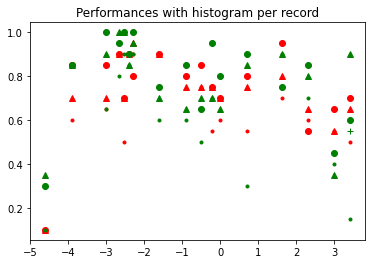

In [21]:
for i in range(len(tauz)):
    j = np.log(tauz[i])
    plt.plot(j,BA_score[i], 'r +')
    plt.plot(j,JS_score[i], 'r o')
    plt.plot(j,kNN3_score[i], 'r ^')
    plt.plot(j,kNN6_score[i], 'r .')
    plt.plot(j,BA_scorehom[i], 'g +')
    plt.plot(j,JS_scorehom[i], 'g o')
    plt.plot(j,kNN3_scorehom[i], 'g ^')
    plt.plot(j,kNN6_scorehom[i], 'g .')
    plt.title('Performances with histogram per record')